This dataset contains detail information of more than 6k auto loans, I would like to use this dataset to build a model that predicts the probability of default.

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv("raw_data.csv")
df.shape
df.head(10)

,LoanNumber,GLPrincipalBalance,APR,AmortizedPaymentAmount,PaymentFrequency,DaysPastDue,OriginalValue,CreditScore,Term,AccountStatus
0,1,6499.56,24.00,484.42,MO,1433,10125.0,578.0,60,CH 13 BANKRUPTCY
1,2,1002.10,23.00,421.94,MO,1095,6650.0,0.0,62,CH 13 BANKRUPTCY
2,3,3599.79,24.00,365.07,MO,1342,6400.0,598.0,60,CH 13 BANKRUPTCY
3,4,2451.58,17.95,430.37,MO,1115,13275.0,573.0,60,CH 13 BANKRUPTCY
4,5,3594.28,17.99,369.48,MO,65,9250.0,598.0,72,PAYING
5,6,3595.07,17.95,655.06,MO,101,18800.0,550.0,76,PAYING
6,7,4002.60,16.95,256.81,BW,1258,11375.0,529.0,111,CH 13 BANKRUPTCY
7,8,4448.83,17.95,516.76,MO,0,13925.0,557.0,74,PAYING
8,9,1236.80,18.00,371.59,MO,547,10350.0,481.0,66,CH 13 BANKRUPTCY
9,10,8945.64,17.95,498.13,MO,78,13200.0,0.0,81,REPO HOLD


There are 6271 rows and 10 columns in this dataset. All of the loans that are not in "PAYING" status or more than 120 days past due will be considered as default. 

In [2]:
df["Bad"] = 1 
df.loc[df["AccountStatus"] == "PAYING", "Bad"] = 0
df.loc[df["DaysPastDue"] <= 120, "Bad"] = 0
df.head(10)

,LoanNumber,GLPrincipalBalance,APR,AmortizedPaymentAmount,PaymentFrequency,DaysPastDue,OriginalValue,CreditScore,Term,AccountStatus,Bad
0,1,6499.56,24.00,484.42,MO,1433,10125.0,578.0,60,CH 13 BANKRUPTCY,1
1,2,1002.10,23.00,421.94,MO,1095,6650.0,0.0,62,CH 13 BANKRUPTCY,1
2,3,3599.79,24.00,365.07,MO,1342,6400.0,598.0,60,CH 13 BANKRUPTCY,1
3,4,2451.58,17.95,430.37,MO,1115,13275.0,573.0,60,CH 13 BANKRUPTCY,1
4,5,3594.28,17.99,369.48,MO,65,9250.0,598.0,72,PAYING,0
5,6,3595.07,17.95,655.06,MO,101,18800.0,550.0,76,PAYING,0
6,7,4002.60,16.95,256.81,BW,1258,11375.0,529.0,111,CH 13 BANKRUPTCY,1
7,8,4448.83,17.95,516.76,MO,0,13925.0,557.0,74,PAYING,0
8,9,1236.80,18.00,371.59,MO,547,10350.0,481.0,66,CH 13 BANKRUPTCY,1
9,10,8945.64,17.95,498.13,MO,78,13200.0,0.0,81,REPO HOLD,0


Drop the rows with missing values.

In [3]:
df.dropna(axis="rows")
df.describe()

,LoanNumber,GLPrincipalBalance,APR,AmortizedPaymentAmount,DaysPastDue,OriginalValue,CreditScore,Term,Bad
count,6271.000000,6271.000000,6271.00000,6271.000000,6271.000000,6271.000000,5869.000000,6271.000000,6271.000000
mean,3136.000000,12245.906997,16.91212,380.893303,48.525435,11395.755972,499.328846,77.325945,0.077340
std,1810.426101,7903.566863,4.63455,129.318993,172.659384,7548.842487,222.464051,104.052843,0.267152
min,1.000000,1000.500000,0.01000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,1568.500000,5917.760000,12.32000,298.000000,0.000000,6175.000000,505.000000,58.000000,0.000000
50%,3136.000000,11156.290000,17.50000,367.610000,0.000000,10704.000000,580.000000,72.000000,0.000000
75%,4703.500000,16864.920000,21.00000,445.100000,18.000000,15587.500000,630.000000,72.000000,0.000000
max,6271.000000,49024.500000,29.99000,1520.420000,1820.000000,62650.000000,810.000000,2131.000000,1.000000


Drop the outliers.

In [4]:
dropped = df[(df.APR < 10) | 
             (df.AmortizedPaymentAmount < 100) | 
             (df.OriginalValue < 500) | 
             (df.CreditScore < 350) | 
             (df.Term < 5)]
clean_data = df.drop(dropped.index).reset_index(drop=True)
clean_data

,LoanNumber,GLPrincipalBalance,APR,AmortizedPaymentAmount,PaymentFrequency,DaysPastDue,OriginalValue,CreditScore,Term,AccountStatus,Bad
0,1,6499.56,24.00,484.42,MO,1433,10125.0,578.0,60,CH 13 BANKRUPTCY,1
1,3,3599.79,24.00,365.07,MO,1342,6400.0,598.0,60,CH 13 BANKRUPTCY,1
2,4,2451.58,17.95,430.37,MO,1115,13275.0,573.0,60,CH 13 BANKRUPTCY,1
3,5,3594.28,17.99,369.48,MO,65,9250.0,598.0,72,PAYING,0
4,6,3595.07,17.95,655.06,MO,101,18800.0,550.0,76,PAYING,0
...,...,...,...,...,...,...,...,...,...,...,...
4590,6267,22403.24,21.00,549.69,MO,0,14941.0,588.0,72,PAYING,0
4591,6268,11224.00,23.00,316.41,MO,0,6950.0,551.0,60,PAYING,0
4592,6269,26214.00,10.37,492.62,MO,0,25975.0,604.0,72,PAYING,0
4593,6270,15862.00,11.70,309.12,MO,0,18940.0,684.0,72,PAYING,0


Covnert the payment amount, loan term to monthly base on payment frequency, and calculate the remaining term using np.nper function.

In [5]:
clean_data.loc[clean_data["PaymentFrequency"] == "SM", "Mo_Term"] = round(df["Term"]/2)
clean_data.loc[clean_data["PaymentFrequency"] == "BW", "Mo_Term"] = round(df["Term"]/2.16)
clean_data.loc[clean_data["PaymentFrequency"] == "MO", "Mo_Term"] = round(df["Term"])

clean_data.loc[clean_data["PaymentFrequency"] == "SM", "Mo_Payment"] = clean_data['AmortizedPaymentAmount'] * 2
clean_data.loc[clean_data["PaymentFrequency"] == "BW", "Mo_Payment"] = clean_data['AmortizedPaymentAmount'] * 2.16
clean_data.loc[clean_data["PaymentFrequency"] == "MO", "Mo_Payment"] = clean_data['AmortizedPaymentAmount']

Call np.nper function to calcuate the rem_term, and calculate the seasoning of each loan.

In [6]:
clean_data['Rem_Term'] = np.nper(clean_data["APR"]/1200, clean_data["Mo_Payment"]*-1, clean_data['GLPrincipalBalance'], 0)
clean_data["Rem_Term"] = round(clean_data["Rem_Term"], 0)
clean_data['Seasoning'] = (clean_data["Mo_Term"] - clean_data["Rem_Term"]) / clean_data["Mo_Term"]
clean_data.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: numpy.nper is deprecated and will be removed from NumPy 1.20. Use numpy_financial.nper instead (https://pypi.org/project/numpy-financial/).
  """Entry point for launching an IPython kernel.


,LoanNumber,GLPrincipalBalance,APR,AmortizedPaymentAmount,PaymentFrequency,DaysPastDue,OriginalValue,CreditScore,Term,AccountStatus,Bad,Mo_Term,Mo_Payment,Rem_Term,Seasoning
0,1,6499.56,24.00,484.42,MO,1433,10125.0,578.0,60,CH 13 BANKRUPTCY,1,60.0,484.4200,16.0,0.733333
1,3,3599.79,24.00,365.07,MO,1342,6400.0,598.0,60,CH 13 BANKRUPTCY,1,62.0,365.0700,11.0,0.822581
2,4,2451.58,17.95,430.37,MO,1115,13275.0,573.0,60,CH 13 BANKRUPTCY,1,60.0,430.3700,6.0,0.900000
3,5,3594.28,17.99,369.48,MO,65,9250.0,598.0,72,PAYING,0,60.0,369.4800,11.0,0.816667
4,6,3595.07,17.95,655.06,MO,101,18800.0,550.0,76,PAYING,0,72.0,655.0600,6.0,0.916667
5,7,4002.60,16.95,256.81,BW,1258,11375.0,529.0,111,CH 13 BANKRUPTCY,1,35.0,554.7096,8.0,0.771429
6,8,4448.83,17.95,516.76,MO,0,13925.0,557.0,74,PAYING,0,111.0,516.7600,9.0,0.918919
7,9,1236.80,18.00,371.59,MO,547,10350.0,481.0,66,CH 13 BANKRUPTCY,1,74.0,371.5900,3.0,0.959459
8,11,7241.13,18.00,420.42,MO,0,13225.0,500.0,75,PAYING,0,66.0,420.4200,20.0,0.696970
9,12,2649.18,18.00,455.21,MO,0,13075.0,570.0,74,PAYING,0,81.0,455.2100,6.0,0.925926


Create a correlation heat map.

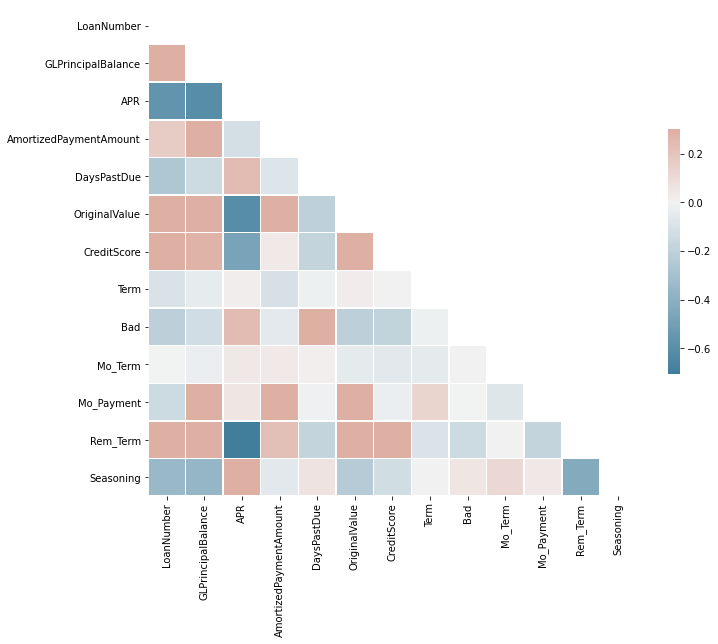

In [7]:
corr = clean_data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Histgram for credit score, most of the borrowers are in the 550 to 650 range.

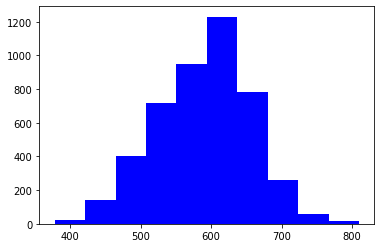

In [8]:
plt.hist(clean_data["CreditScore"], bins=10, color='b')
plt.show()

Save the final data frame to a csv file.

In [9]:
clean_data.to_csv("clean_data.csv", index=False)